In [ ]:
#https://towardsdatascience.com/using-signal-processing-to-extract-neural-events-in-python-964437dc7c0

# Using signal processing and K-means clustering to extract and sort neural events in Python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
%matplotlib inline


#define data path
data_file = "C:/Users/ankita upadhyay/Documents/Python/Python codes/2021/Spike Sorting using signal processing/UCLA_data/CSC4.Ncs"

In [3]:
#Header has 16 kilobytes length
header_size = 16 * 1024

#open file
fid = open(data_file, 'rb')

#skip the header by shifting positions by header size
fid.seek(header_size)

#Read data according to Neuralynx information
data_format = np.dtype([('TimeStamp', np.uint64),
                       ('ChannelNumber', np.uint32),
                       ('SampleFreq', np.uint32),
                       ('NumValidSamples', np.uint32),
                        ('Samples', np.int16, 512)])

raw = np.fromfile(fid, dtype=data_format)

#Close file
fid.close()

#Get sampling frequency
sf = raw['SampleFreq'][0]

#Create Data vector
data = raw['Samples'].ravel()

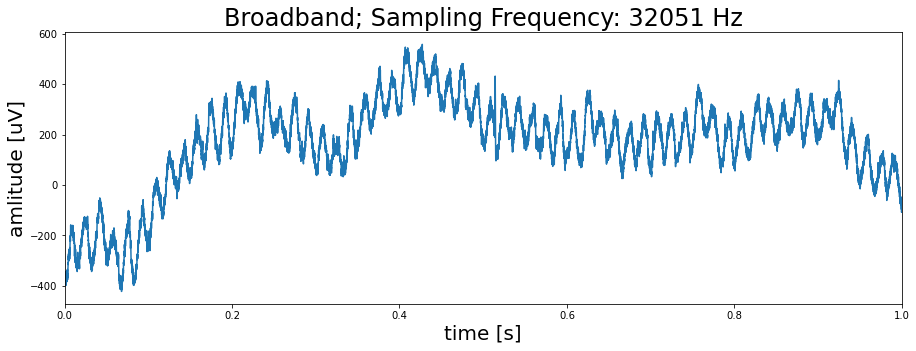

In [4]:
#Determine duration of recording in seconds
dur_sec = data.shape[0]/sf

#create time vector
time = np.linspace(0, dur_sec, data.shape[0])

#Plot first second of data
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(time[0:sf], data[0:sf])
ax.set_title('Broadband; Sampling Frequency: {} Hz'.format(sf), fontsize=24)
ax.set_xlim(0, time[sf])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('amlitude [uV]', fontsize=20)
plt.show()

# Bandpass filter the data


The function below will bandpass filter the signal to exclude the 60Hz domain.

In [5]:
def filter_data (data, low, high, sf, order=2):
    nyq = sf/2
    #determined Nyquist frequency
    
    #set bands
    low = low/nyq
    high = high/nyq
    
    #calculate coefficients
    b, a = butter(order, [low, high], btype='band')
    
    #Filter signal
    filtered_data = lfilter(b, a, data)
    
    return filtered_data

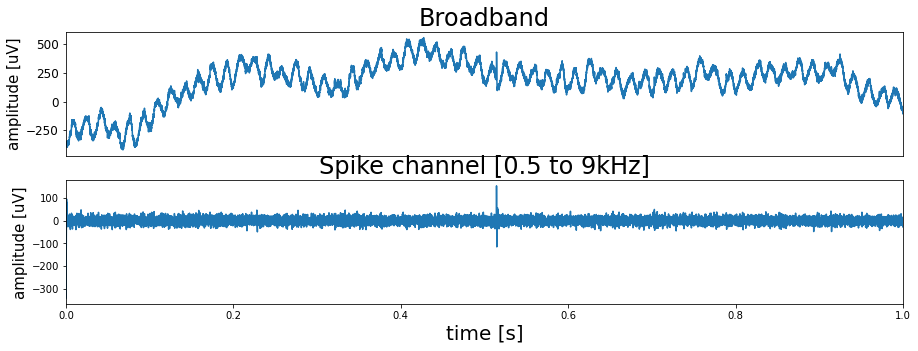

In [6]:
spike_data = filter_data(data, low=500, high=9000, sf=sf)

# Plot signals
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].plot(time[0:sf], data[0:sf])
ax[0].set_xticks([])
ax[0].set_title('Broadband', fontsize=24)
ax[0].set_xlim(0, time[sf])
ax[0].set_ylabel('amplitude [uV]', fontsize=15)
ax[0].tick_params(labelsize=12)

ax[1].plot(time[0:sf], spike_data[0:sf])
ax[1].set_title('Spike channel [0.5 to 9kHz]', fontsize=24)
ax[1].set_xlim(0, time[sf])
ax[1].set_xlabel('time [s]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=15)
ax[1].tick_params(labelsize=10)
plt.show()

# Extract Spikes from the filtered signal
We will identify and extract spikes

Inputs:
    1. Filtered Data
    2. No of Samples
    3. Threshold Factor
    4. Upper Threshold
    5. Offset Data

In [7]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    
    #Calculate threshold based on data mean
    thresh = np.mean(np.abs(data))*tf
    
    #Find positions where the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]
    
    #Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from positions where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]
            
            #Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                #Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) + i
                
                #Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]
                
                #Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
                
    #Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]
                
    return spike_samp, wave_form

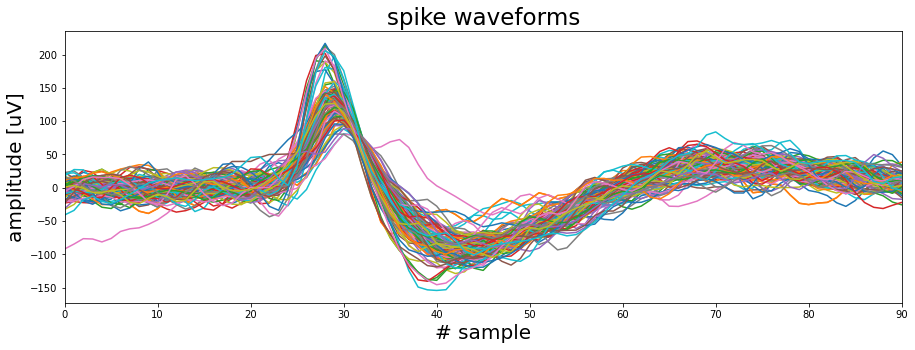

In [8]:
spike_samp, wave_form = get_spikes(spike_data, spike_window=50, tf=8, offset=20)

np.random.seed(10)
fig, ax = plt.subplots(figsize=(15,5))

for i in range(100):
    spike = np.random.randint(0, wave_form.shape[0])
    ax.plot(wave_form[spike, :])
    
ax.set_xlim([0, 90])
ax.set_xlabel('# sample', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
ax.set_title('spike waveforms', fontsize=23)
plt.show()

# Reducing the number of dimensions with PCA

PCA - Principal component analysis 

PCA is a dimensionality reduction method which requires normalized data

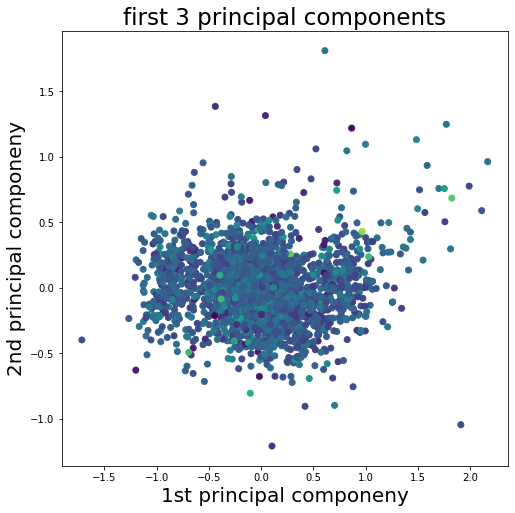

In [12]:
import sklearn as sk
from sklearn.decomposition import PCA

#Apply min-max scaling
scaler = sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(wave_form)

#Do PCA
pca = PCA(n_components=12)
pca_result = pca.fit_transform(dataset_scaled)

# Plot the 1st principal component against the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal componeny', fontsize=20)
ax.set_ylabel('2nd principal componeny', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()